## bibliotecas a serem usadas

In [1]:
import plotly_express as px
# biblioteca nova, para visualização com diferentes formas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [2]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

%matplotlib inline
plt.rcParams.update(params)

### arquivo_dados_formatados_agrupados

In [3]:
df=pd.read_csv('d_f_a_2.csv',encoding = "ISO-8859-1", sep=";", low_memory=False, nrows=1000000)
# somente 100 mil linhas, tempo computação adequável

In [5]:
df.head(1)

,cod_muni,qtd_mora,incidencia,diag_princ,prevalencia,renda_media_mora,SITU1_entorno,SITU2_entorno,SITU3_entorno,SITU4_entorno,...,V032_domicilio02,V033_domicilio02,V034_domicilio02,V035_domicilio02,V036_domicilio02,V037_domicilio02,V038_domicilio02,V041_domicilio02,V045_domicilio02,V089_domicilio02
0,290010,8301,1,J04,0.000121,0.103943,0.463481,0.0,0.0,0.0,...,0.005892,0.39911,0.016835,0.035354,0.0,0.010582,0.970779,0.027417,0.490861,0.509139


In [6]:
df1=pd.read_csv('dados_com-clima_censo_com_selecao.csv',encoding = "ISO-8859-1", sep=";", low_memory=False, nrows=1000000)

In [7]:
df1.head(2)

,cod_muni,renda_media_mora,SITU1_entorno,SITU2_entorno,SITU3_entorno,SITU4_entorno,SITU5_entorno,SITU6_entorno,SITU7_entorno,SITU8_entorno,...,V032_domicilio02,V033_domicilio02,V034_domicilio02,V035_domicilio02,V036_domicilio02,V037_domicilio02,V038_domicilio02,V041_domicilio02,V045_domicilio02,V089_domicilio02
0,290010,0.103943,0.463481,0.0,0.0,0.0,0.083528,0.0,0.0,0.452991,...,0.005892,0.39911,0.016835,0.035354,0.000000,0.010582,0.970779,0.027417,0.490861,0.509139
1,290020,0.036980,0.548910,0.0,0.0,0.0,0.127955,0.0,0.0,0.323134,...,0.109294,0.19462,0.004395,0.249180,0.000176,0.024848,0.909341,0.086381,0.501875,0.498125


### Doença mais frequente = K40

In [6]:
# separação na doença mais frequente desse arquivo = K40
temp = np.where(df['diag_princ'].isin(['K40']))
df40 = df.loc[temp]
# reunir tudo
df40.head(3)

,cod_muni,qtd_mora,incidencia,diag_princ,prevalencia,renda_media_mora,SITU1_entorno,SITU2_entorno,SITU3_entorno,SITU4_entorno,...,V032_domicilio02,V033_domicilio02,V034_domicilio02,V035_domicilio02,V036_domicilio02,V037_domicilio02,V038_domicilio02,V041_domicilio02,V045_domicilio02,V089_domicilio02
18,290010,8301,24,K40,0.002891,0.103943,0.463481,0.0,0.0,0.0,...,0.005892,0.399110,0.016835,0.035354,0.000000,0.010582,0.970779,0.027417,0.490861,0.509139
53,290020,16991,50,K40,0.002943,0.036980,0.548910,0.0,0.0,0.0,...,0.109294,0.194620,0.004395,0.249180,0.000176,0.024848,0.909341,0.086381,0.501875,0.498125
98,290030,14503,97,K40,0.006688,0.063205,0.887555,0.0,0.0,0.0,...,0.006756,0.374053,0.024022,0.037399,0.000409,0.006142,0.970859,0.018904,0.491913,0.508087


## XGBOOST_Predição

In [7]:
!pip install xgboost

In [8]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### arquivo_preparo

In [9]:
# Preparação dos arquivos de entrada (X) e saída (y)
X = df40[['cod_muni','SITU1_entorno','SITU5_entorno','renda_media_mora','V032_domicilio02','V034_domicilio02','V035_domicilio02']]
y = df40.loc[:,'prevalencia']

In [10]:
X.head(2)

,cod_muni,SITU1_entorno,SITU5_entorno,renda_media_mora,V032_domicilio02,V034_domicilio02,V035_domicilio02
18,290010,0.463481,0.083528,0.103943,0.005892,0.016835,0.035354
53,290020,0.548910,0.127955,0.036980,0.109294,0.004395,0.249180


In [11]:
y.head(2)

18    0.002891
53    0.002943
Name: prevalencia, dtype: float64

In [12]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, random_state=1234)

### Baseline

In [13]:
# regressor com ajuste inicial
regressor = xgb.XGBRegressor(learning_rate=0.1,
                             subsample=1,colsample_bytree=1,n_estimators=1000,
                             reg_lambda=1,gamma=1,max_depth=3,missing=0.01)

In [14]:
# preparação do regressor
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=0.01, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [15]:
y_pred = regressor.predict(X_test)

In [16]:
y_pred

array([0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484

In [17]:
mean_squared_error(y_test, y_pred)

4.979770575507606e-06

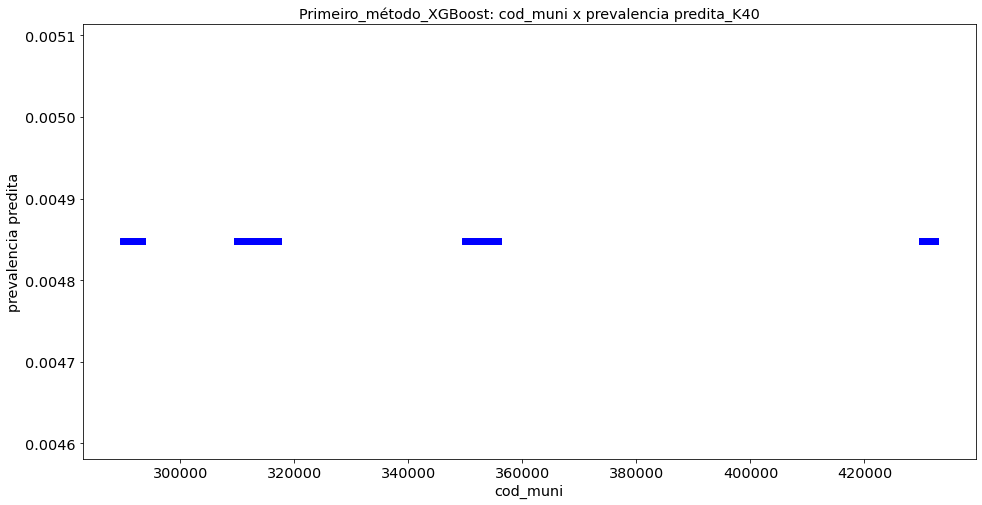

In [18]:
plt.scatter(X_test['cod_muni'], y_pred, c = "blue", marker = "s")
plt.title("Primeiro_método_XGBoost: cod_muni x prevalencia predita_K40")
plt.xlabel("cod_muni")
plt.ylabel("prevalencia predita")
plt.show()

In [19]:
errop1= (y_test - y_pred)*100/y_test
# em porcentagem

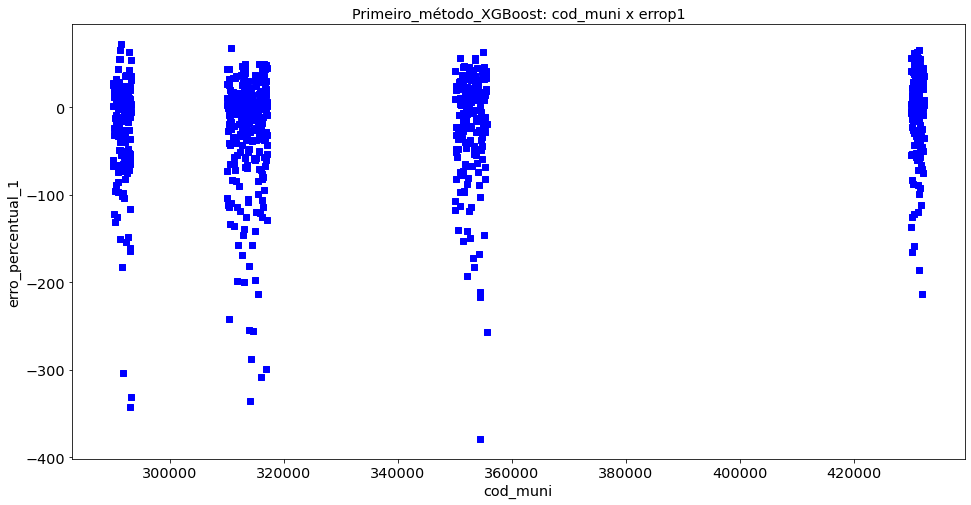

In [20]:
plt.scatter(X_test['cod_muni'], errop1, c = "blue", marker = "s")
plt.title("Primeiro_método_XGBoost: cod_muni x errop1")
plt.xlabel("cod_muni")
plt.ylabel("erro_percentual_1")
plt.show()

### Otimização método XGBoost

In [21]:
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [22]:
regressor = xgb.XGBRegressor()

In [23]:
random_search = RandomizedSearchCV(regressor,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [24]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    4.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.6s finished


[11:24:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { learning rate, max depth, min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_con...
                   iid='warn', n_iter=5, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear',
                                                    'dart'],
                                        'colsa

In [25]:
print(random_search.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.1, learning_rate=0.300000012, max depth=5,
             max_delta_step=0, max_depth=6, min_child_weight=1,
             min_child_weigth=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [26]:
random_search.best_params_

{'min_child_weigth': 1,
 'max depth': 5,
 'learning rate': 0.1,
 'gamma': 0.3,
 'colsample_bytree': 0.6,
 'booster': 'gbtree'}

In [27]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=10)

In [28]:
modelb = xgb.XGBRegressor(colsample_bytree=0.6,
                 gamma=0,                 
                 learning_rate=0.2,
                 max_depth=5,
                 min_child_weight=1,
                 n_estimators=100,                                                                    
                 reg_alpha=0,
                 reg_lambda=1,
                 subsample=1,
                 seed=42, booster = 'dart') 

In [29]:
modelb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
y_pred_2 = modelb.predict(X_test)

In [31]:
mean_squared_error(y_test, y_pred_2)

4.966916045057161e-06

In [32]:
errop2= (y_test - y_pred_2)*100/y_test
# em porcentagem

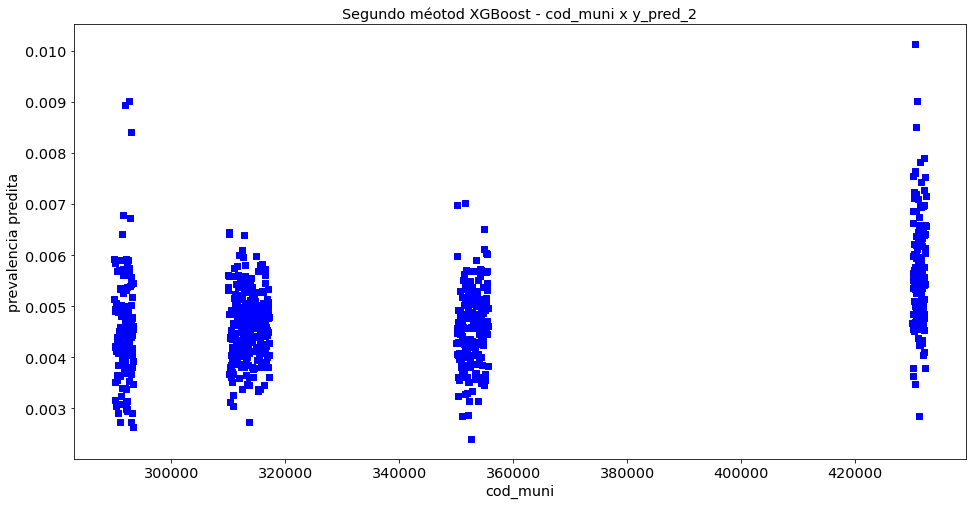

In [33]:
plt.scatter(X_test['cod_muni'], y_pred_2, c = "blue", marker = "s")
plt.title("Segundo méotod XGBoost - cod_muni x y_pred_2")
plt.xlabel("cod_muni")
plt.ylabel("prevalencia predita")
plt.show()

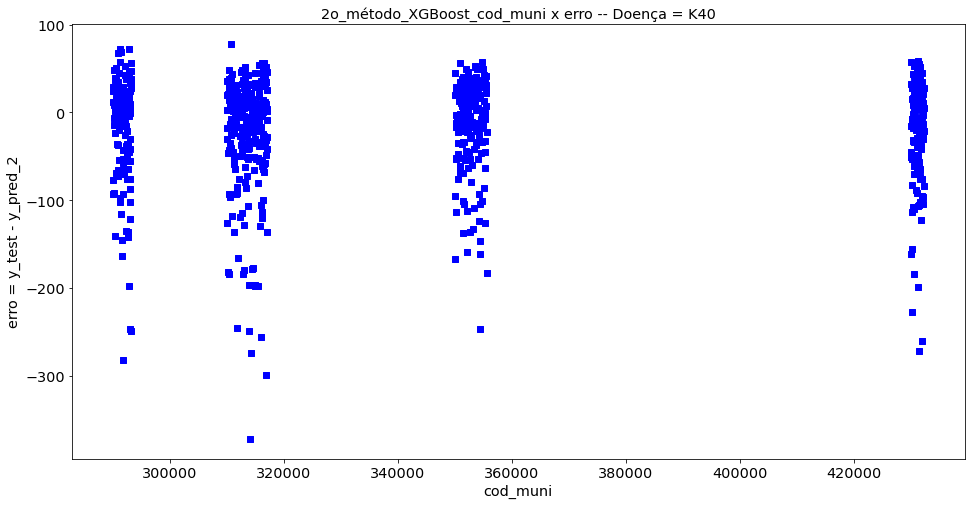

In [34]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("2o_método_XGBoost_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("erro = y_test - y_pred_2")
plt.show()

### Comparação dos erros percentuais

In [35]:
comp = errop2/errop1
# errop2 - otimização com dart
# errop1 - baseline (caso mais simples)

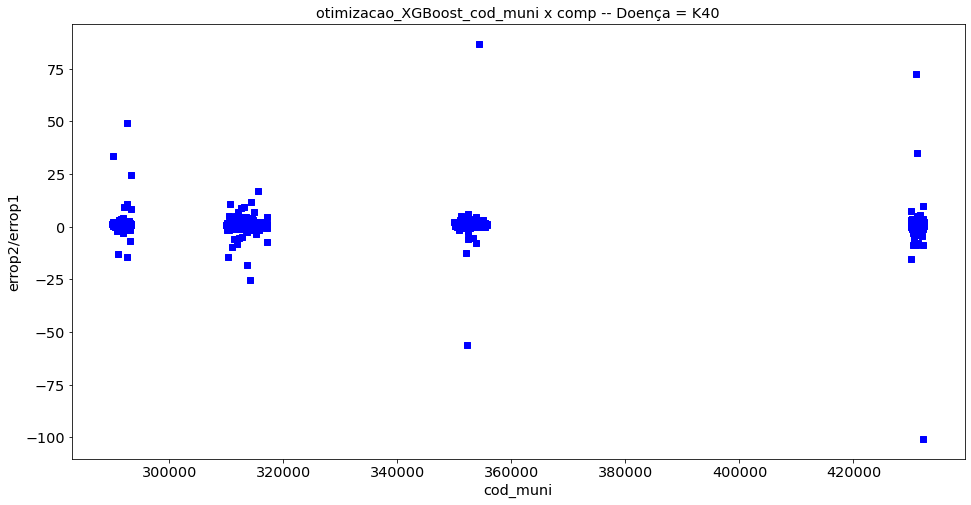

In [36]:
plt.scatter(X_test['cod_muni'], comp, c = "blue", marker = "s")
plt.title("otimizacao_XGBoost_cod_muni x comp -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2/errop1")
plt.show()

<AxesSubplot:>

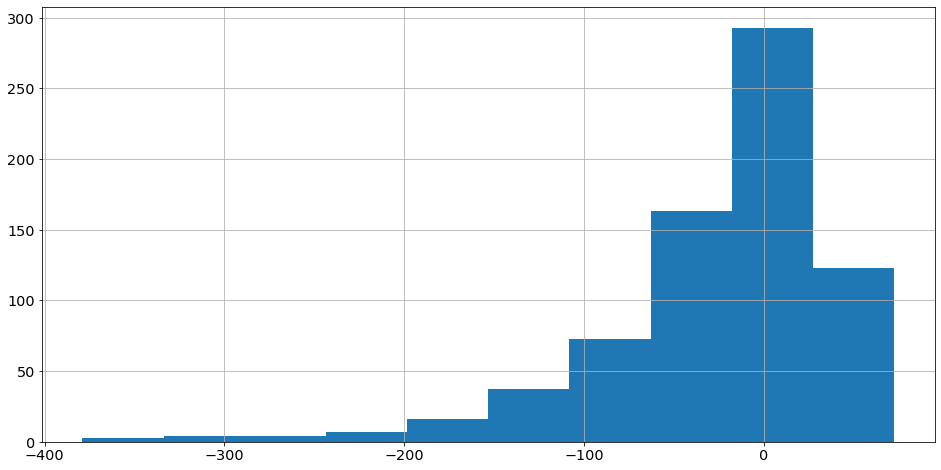

In [37]:
errop1.hist()

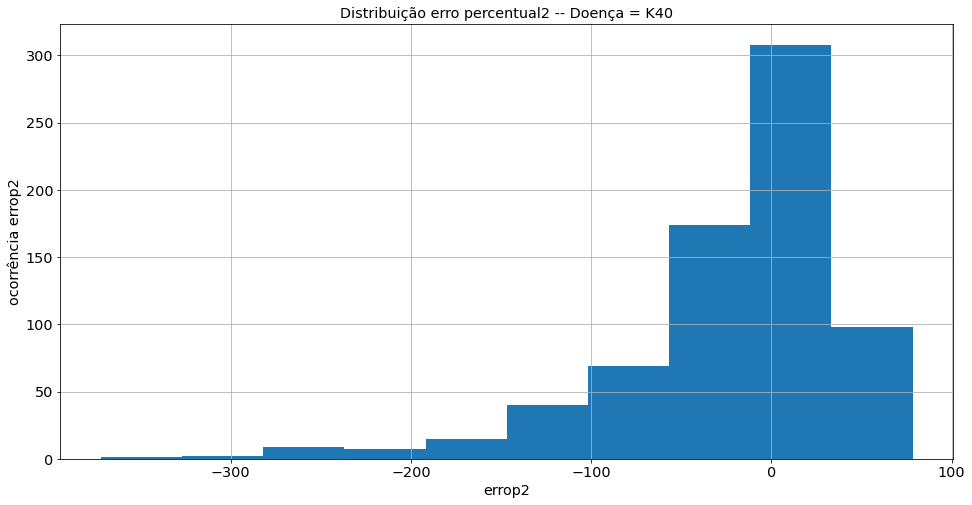

In [39]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()